This code models several models to assess the length of stay in Saint Lucia. 

This code chunk loads the data and performs the following cleaning techniques:
    removes instances where there are blank values which are codied as -1
    removes ages more than 100 years
    defines tourist as between 1-365 nights
    streamlines purpose of visit
    logs variables
    makes a continous and categorical variables


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families.family import NegativeBinomial
import tkinter as tk
from tkinter import filedialog
from scipy import stats
from docx import Document
from docx.shared import Inches
from io import BytesIO
import statsmodels.discrete.discrete_model as discrete
from statsmodels.regression.mixed_linear_model import MixedLM

def select_file(title, file_types, save=False):
    """Allow user to select a file"""
    root = tk.Tk()
    root.withdraw()
    root.attributes('-topmost', True)
    
    try:
        if save:
            file_path = filedialog.asksaveasfilename(
                title=title,
                filetypes=file_types,
                defaultextension=file_types[0][1]
            )
        else:
            file_path = filedialog.askopenfilename(
                title=title,
                filetypes=file_types
            )
    finally:
        root.destroy()
    
    return file_path if file_path else None

# Allow user to select input file
print("Please select the input Excel file...")
file_path = select_file(
    "Select Excel Data File", 
    [("Excel files", "*.xlsx *.xls"), ("All files", "*.*")]
)

if not file_path:
    print("No file selected. Exiting.")
    exit()

# Import the data
print(f"Loading data from: {file_path}")
df = pd.read_excel(file_path, sheet_name="Sheet")

# Setup
pd.set_option('display.max_columns', None)

# Encode categorical variables if not already encoded
categorical_vars = ['sex', 'marital_status', 'employment_status', 'purpose', 'accomd_type', 'us_state','tourist_type']
encoded_vars = {}

for var in categorical_vars:
    if var in df.columns:
        # Check if variable is already numeric
        if not pd.api.types.is_numeric_dtype(df[var]):
            new_var = f"{var}_enc"
            df[new_var] = pd.Categorical(df[var]).codes
            encoded_vars[var] = new_var
        else:
            encoded_vars[var] = var

# Set the truncation point for los (assuming truncation at 0)
df['los_trunc'] = df['los'].copy()
df.loc[df['los_trunc'] <= 0, 'los_trunc'] = np.nan

# Check for missing data
print("\nMissing data summary:")
missing_data_summary = df.isnull().sum()
print(missing_data_summary)

print("\nMissing data patterns:")
missing_patterns = df.isnull().sum(axis=1)
missing_patterns_counts = missing_patterns.value_counts().sort_index()
print(missing_patterns_counts)

# Visualize los distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['los_trunc'], discrete=True)
plt.title('Histogram of Length of Stay')
plt.tight_layout()
los_hist_img = BytesIO()
plt.savefig(los_hist_img, format='png')
los_hist_img.seek(0)
plt.close()

# Summarize los by purpose
purpose_stats = None
if 'purpose_enc' in df.columns:
    print("\nLength of stay by purpose:")
    purpose_stats = df.groupby('purpose_enc')['los_trunc'].agg(['count', 'mean', 'median', 'min', 'max', 'std'])
    print(purpose_stats)

# Detailed summary of los_trunc
print("\nDetailed summary of length of stay:")
los_describe = df['los_trunc'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
print(los_describe)

# Cleaning process
# Step 1: Drop missing datapoints for key variables
key_vars = ['los', 'immigrant_population', 'import_from_slu', 'age', 
            encoded_vars.get('sex', 'sex_enc'), 
            encoded_vars.get('marital_status', 'marital_status_enc'), 
            encoded_vars.get('employment_status', 'employment_status_enc'), 
            'distance_miles', 
            encoded_vars.get('purpose', 'purpose_enc'), 
            encoded_vars.get('accomd_type', 'accomd_type_enc'), 
            encoded_vars.get('tourist_type', 'tourist_type_enc'),
            'month_travel', 'state_percapita_income', 'state_unemployment','immigrant_density']

#Now that we have the encoded variables, we need to remove blank and -1 values
# Remove rows where sex_enc is -1
df = df[df['sex_enc'] != -1]
# Remove rows where age > 100
df = df[df['age'] <= 100]  
# Remove rows where marital_status_enc is -1
df= df[df['marital_status_enc'] != -1]

#Remove rows where employment_status_enc is -1
df = df[df['employment_status_enc'] != -1]

# Count missing values per row for key variables
df['missing'] = df[key_vars].isnull().sum(axis=1)
print("\nNumber of missing values per observation:")
missing_values_count = df['missing'].value_counts().sort_index()
print(missing_values_count)

# Drop observations with missing values in key variables
df_clean = df[df['missing'] == 0].drop('missing', axis=1)
print(f"\nRemaining observations after dropping missing values: {len(df_clean)}")

# Step 2: Drop outliers in length of stay
#02 June 2025 edit removed the windorization of los_trunc
#los_p95 = np.percentile(df_clean['los_trunc'].dropna(), 95)
df_clean['los_capped'] = df_clean['los_trunc'].copy()
#df_clean.loc[df_clean['los_capped'] > los_p95, 'los_capped'] = los_p95

#df_clean = df_clean[df_clean['los_trunc'] <= los_p95]
print(f"After filtering to 95th percentile, remaining observations: {len(df_clean)}")

# Remove any instance of los_capped that is less than 2. Prior to this, over 1000 persons had stays less than 1 including honeymooners. This appears to be a data entry error.
#02 June 2025 edit use the tourism definition of length of stay where its more than 1 day and less than 366 days

df_clean = df_clean[(df_clean['los_capped'] > 1) & (df_clean['los_capped'] < 366)]  # Keep stays more than 1 and less than 366 days

#remove instances where sex_enc is -1



# Visualize the capped los distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['los_capped'], discrete=True)
plt.title('Histogram of Capped Length of Stay')
plt.tight_layout()
los_capped_img = BytesIO()
plt.savefig(los_capped_img, format='png')
los_capped_img.seek(0)
plt.close()

# Step 3: Clean up the purpose of trip column
# Create a new simplified purpose variable
purpose_mapping = {
    1: 1,  # BUSINESS/MEETING -> Business
    2: 1,  # CONVENTION -> Business
    3: 1,  # CREW -> Business
    5: 2,  # EVENT -> Events
    6: 2,  # EVENTS -> Events
    7: 4,  # HONEYMOON -> Pleasure
    8: 5,  # INTRANSIT PASSEN -> Other
    9: 5,  # OTHER -> Other
    10: 4, # PLEASURE/HOLIDAY -> Pleasure
    11: 5, # RESIDENT -> Other
    12: 2, # SAINT LUCIA CARN -> Events
    13: 2, # SAINT LUCIA JAZZ -> Events
    14: 5, # SPORTS -> Other
    15: 5, # STUDY -> Other
    16: 5, # VISITING FRIENDS -> Other
    17: 3, # WEDDING -> Wedding
    18: 4, # pLEASURE/HOLIDAY -> Pleasure
    4: 5,  # CRICKET -> Other
}

purpose_labels = {
    1: "Business",
    2: "Events",
    3: "Wedding",
    4: "Pleasure",
    5: "Other"
}

# Add the simplified purpose variable
purpose_enc_col = encoded_vars.get('purpose', 'purpose_enc')
df_clean['purpose_simple'] = df_clean[purpose_enc_col].map(purpose_mapping)

# Check the new variable
print("\nPurpose simple distribution:")
purpose_counts = df_clean['purpose_simple'].value_counts().sort_index()
purpose_distribution = []
for code, count in purpose_counts.items():
    purpose_line = f"{code} ({purpose_labels.get(code, 'Unknown')}): {count}"
    purpose_distribution.append(purpose_line)
    print(purpose_line)

# Create a Word document for output
doc = Document()
doc.add_heading('Multilevel Truncated Negative Binomial Regression for Length of Stay Analysis', 0)
doc.add_heading('Data Preparation and Cleaning', level=1)



# Add Length of Stay histogram
doc.add_paragraph('\n')
doc.add_heading('Length of Stay Distribution', level=2)
doc.add_picture(los_hist_img, width=Inches(6))
doc.add_paragraph('Figure 1: Histogram of Length of Stay (Before Capping)')

# Add Capped LOS histogram
doc.add_paragraph('\n')
doc.add_heading('Capped Length of Stay Distribution', level=2)
doc.add_picture(los_capped_img, width=Inches(6))
doc.add_paragraph('Figure 2: Histogram of Length of Stay (After Capping at 95th Percentile)')

# Add LOS summary statistics
doc.add_paragraph('\n')
doc.add_heading('Length of Stay Summary Statistics', level=2)
los_stats_table = doc.add_table(rows=len(los_describe)+1, cols=2)
los_stats_table.style = 'Table Grid'
los_stats_table.cell(0, 0).text = 'Statistic'
los_stats_table.cell(0, 1).text = 'Value'
for i, (stat, value) in enumerate(los_describe.items(), 1):
    los_stats_table.cell(i, 0).text = str(stat)
    los_stats_table.cell(i, 1).text = f"{value:.4f}" if isinstance(value, (int, float)) else str(value)

# Add Purpose distribution
doc.add_paragraph('\n')
doc.add_heading('Purpose of Visit Distribution', level=2)
purpose_table = doc.add_table(rows=len(purpose_distribution)+1, cols=1)
purpose_table.style = 'Table Grid'
purpose_table.cell(0, 0).text = 'Purpose Category'
for i, purpose_text in enumerate(purpose_distribution, 1):
    purpose_table.cell(i, 0).text = purpose_text

# Log continuous variables
# Convert columns to numeric before log transformation
for col in ['immigrant_population', 'import_from_slu', 'distance_miles', 'state_percapita_income']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

df_clean['log_age'] = np.log1p(df_clean['age'])
df_clean['immigrant_population_log'] = np.log1p(df_clean['immigrant_population'])
df_clean['distance_miles_log'] = np.log1p(df_clean['distance_miles'])
df_clean['state_percapita_income_log'] = np.log1p(df_clean['state_percapita_income'])
df_clean['import_from_slu_log'] = np.log1p(df_clean['import_from_slu'])




# Fit simple negative binomial regression with continuous variables correctly specified
print("\nFitting simple negative binomial regression model...")
doc.add_paragraph('\n')
doc.add_heading('Negative Binomial Regression Model', level=1)

# Define continuous variables and create proper formula
continuous_vars = ['immigrant_population_log', 'import_from_slu_log', 'log_age', 'distance_miles_log', 
                   'state_percapita_income_log', 'state_unemployment','immigrant_density']

# Make sure all continuous variables are properly formatted as numeric
for var in continuous_vars:
    if var in df_clean.columns:
        df_clean[var] = pd.to_numeric(df_clean[var], errors='coerce')

# Create formula with continuous variables properly treated
formula_parts = []
for var in continuous_vars:
    if var in df_clean.columns:
        formula_parts.append(var)

# Add categorical variables with proper C() notation
categorical_model_vars = ['sex_enc', 'marital_status_enc', 'employment_status_enc', 
                         'purpose_simple', 'accomd_type_enc', 'month_travel', 'us_state_enc','tourist_type_enc']

for var in categorical_model_vars:
    if var in df_clean.columns:
        # Use the encoded variable name or the original if available
        var_to_use = var
        formula_parts.append(f"C({var_to_use})")

# Combine into final formula
formula = 'los_capped ~ ' + ' + '.join(formula_parts)
print(f"Model formula: {formula}")

# Add formula to document
doc.add_paragraph(f"Model formula: {formula}")

# Drop rows with missing values in formula variables

formula_vars = ['los_capped'] + continuous_vars + categorical_model_vars
df_clean_nb = df_clean[formula_vars].dropna()
df_clean_nb = df_clean_nb.reset_index(drop=True)
print(f"Number of rows in df_clean_nb after dropping missing values: {len(df_clean_nb)}")





The first code chunk loads the data and runs two negative binomials. In each case all continous data is in logs form with the exception of length of stay and continous variables which are ratio's such as the unemployment rate. 

The first negative binomial runs all variables. In that model we see that the VIF for age, distance and state per capita exceeds 100. We also note that the state per capita variable is insignificant. Marital status and employment status are insignificant. The immigrant popuulation variable has a VIF in excess of 20
and it may be prudent to remove this since we have a migrant density variable. Removing this variable however results in the immigrant density variaable turning from a positive to a negative effect. Consquently both are kept since removing the immigrant population seems to have an effect that needs to be captured. 

The second negative binomial attempts to address the issues with the first by removing state per capita and martial and employment status as they were insignificant while state per capita had a high VIF.

In the simpler model age and distance now have the highest VIF.

/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Negative Binomial Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:             los_capped   No. Observations:               138553
Model:                            GLM   Df Residuals:                   138475
Model Family:        NegativeBinomial   Df Model:                           77
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.1474e+05
Date:                Fri, 06 Jun 2025   Deviance:                       36191.
Time:                        11:40:57   Pearson chi2:                 2.71e+05
No. Iterations:                    50   Pseudo R-squ. (CS):            0.02811
Covariance Type:            nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



Negative Binomial Regression Results (Simpler Model):
                 Generalized Linear Model Regression Results                  
Dep. Variable:             los_capped   No. Observations:               138553
Model:                            GLM   Df Residuals:                   138481
Model Family:        NegativeBinomial   Df Model:                           71
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.1475e+05
Date:                Fri, 06 Jun 2025   Deviance:                       36217.
Time:                        11:41:32   Pearson chi2:                 2.72e+05
No. Iterations:                   100   Pseudo R-squ. (CS):            0.02793
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

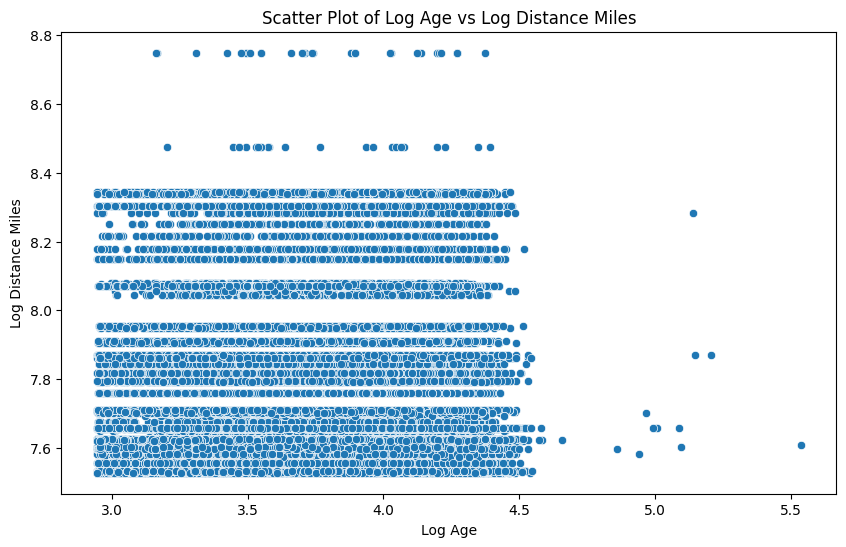

FileNotFoundError: [Errno 2] No such file or directory: 'scatter_plot,png'

In [ ]:

# Fit negative binomial model with all variables
nb_model = smf.glm(formula=formula, 
                  data=df_clean_nb, 
                  family=sm.families.NegativeBinomial(link=sm.families.links.log()))

try:
    nb_results = nb_model.fit()
    print("\nNegative Binomial Regression Results:")
    summary_text = str(nb_results.summary())
    print(summary_text)
    
    # Add model summary to document
    #doc.add_paragraph('\nModel Summary:')
    summary_paragraph_neg = doc.add_paragraph()
    summary_run_neg = summary_paragraph_neg.add_run(summary_text)
    summary_run_neg.font.name = 'Courier New'  # Use monospace font
    #for line in summary_text.split('\n'):
        #doc.add_paragraph(line)
    
    # Convert coefficients to incident rate ratios (IRR)
    print("\nIncident Rate Ratios (IRR):")
    irr = np.exp(nb_results.params)
    irr_conf = np.exp(nb_results.conf_int())
    irr_df = pd.DataFrame({'IRR': irr, 'Lower CI': irr_conf[0], 'Upper CI': irr_conf[1], 
                          'P-value': nb_results.pvalues})
    print(irr_df)
    
    # Add IRR table to document
    doc.add_paragraph('\n')
    doc.add_heading('Incident Rate Ratios (IRR)', level=2)
    irr_table = doc.add_table(rows=len(irr_df)+1, cols=5)
    irr_table.style = 'Table Grid'
    irr_table.cell(0, 0).text = 'Variable'
    irr_table.cell(0, 1).text = 'IRR'
    irr_table.cell(0, 2).text = 'Lower CI'
    irr_table.cell(0, 3).text = 'Upper CI'
    irr_table.cell(0, 4).text = 'P-value'
    
    for i, (var, row) in enumerate(irr_df.iterrows(), 1):
        irr_table.cell(i, 0).text = str(var)
        irr_table.cell(i, 1).text = f"{row['IRR']:.4f}"
        irr_table.cell(i, 2).text = f"{row['Lower CI']:.4f}"
        irr_table.cell(i, 3).text = f"{row['Upper CI']:.4f}"
        irr_table.cell(i, 4).text = f"{row['P-value']:.4f}"
    
    
    # Predictions and diagnostics
    df_clean_nb['predicted'] = nb_results.predict()
    df_clean_nb['residuals'] = df_clean_nb['los_capped'] - df_clean_nb['predicted']
    
    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean_nb['predicted'], df_clean_nb['residuals'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.tight_layout()
    residuals_img = BytesIO()
    plt.savefig(residuals_img, format='png')
    residuals_img.seek(0)
    plt.close()
    
    # Add residuals plot to document
    doc.add_paragraph('\n')
    doc.add_heading('Diagnostics', level=2)
    doc.add_picture(residuals_img, width=Inches(6))
    doc.add_paragraph('Figure 3: Residuals Plot')

    #Add VIF for continuous variables and categorical variables
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df_clean_nb[continuous_vars + categorical_model_vars].columns
    vif_data["VIF"] = [variance_inflation_factor(df_clean_nb[continuous_vars + categorical_model_vars].values, i) 
                       for i in range(df_clean_nb[continuous_vars + categorical_model_vars].shape[1])]
    print("VIF for continuous and dummy variables:")
    print(vif_data)

    #Add VIF table to document
    doc.add_paragraph('\nVariance Inflation Factor (VIF) for Continuous and Categorical Variables:')    
    vif_table = doc.add_table(rows=len(vif_data)+1, cols=2)
    vif_table.style = 'Table Grid'
    vif_table.cell(0, 0).text = 'Variable'
    vif_table.cell(0, 1).text = 'VIF'
    for i, (var, vif) in enumerate(zip(vif_data["Variable"], vif_data["VIF"]), 1):
        vif_table.cell(i, 0).text = str(var)
        vif_table.cell(i, 1).text = f"{vif:.4f}"
    doc.add_paragraph('VIF values above 10 indicate potential multicollinearity issues.')
#except Exception as e:
    #error_msg = f"Error fitting negative binomial model: {str(e)}"
    #print(error_msg)
    #doc.add_paragraph(error_msg)
    #doc.add_paragraph("The negative binomial regression model failed to converge. This can happen due to " +
                     #"insufficient variation in the data or other model specification issues.")
    

# Fit a negative binomial model with fewer variables

#New continuous variables for the simpler model
    continuous_vars_simple = [ 'immigrant_population_log','import_from_slu_log', 'log_age', 'distance_miles_log', 
                    'state_unemployment','immigrant_density']

#New categorical variables for the simpler model

    categorical_model_vars_simple = ['sex_enc',  
                         'purpose_simple', 'accomd_type_enc', 'month_travel', 'us_state_enc','tourist_type_enc']
    
#New formula for the simpler model
    formula_parts_simple = []
    for var in continuous_vars_simple:
        if var in df_clean_nb.columns:
            formula_parts_simple.append(var)
    # Add categorical variables with proper C() notation
    for var in categorical_model_vars_simple:
        if var in df_clean_nb.columns:
            # Use the encoded variable name or the original if available
            var_to_use = var
            formula_parts_simple.append(f"C({var_to_use})")
    # Combine into final formula
    formula_simple = 'los_capped ~ ' + ' + '.join(formula_parts_simple)
    print(f"Model formula for simpler model: {formula_simple}")
    # Add formula to document
    doc.add_paragraph(f"Model formula for simpler model: {formula_simple}")

# Fit negative binomial model with fewer variables
    nb_model_simple = smf.glm(formula=formula_simple, 
                          data=df_clean_nb, 
                          family=sm.families.NegativeBinomial(link=sm.families.links.log()))
    try:
        nb_results_simple = nb_model_simple.fit()
        print("\nNegative Binomial Regression Results (Simpler Model):")
        summary_text_simple = str(nb_results_simple.summary())
        print(summary_text_simple)
        
        # Add model summary to document
        summary_paragraph_neg_simple = doc.add_paragraph()
        summary_run_neg_simple = summary_paragraph_neg_simple.add_run(summary_text_simple)
        summary_run_neg_simple.font.name = 'Courier New'  # Use monospace font
        
        # Convert coefficients to incident rate ratios (IRR)
        print("\nIncident Rate Ratios (IRR) for Simpler Model:")
        irr_simple = np.exp(nb_results_simple.params)
        irr_conf_simple = np.exp(nb_results_simple.conf_int())
        irr_df_simple = pd.DataFrame({'IRR': irr_simple, 'Lower CI': irr_conf_simple[0], 'Upper CI': irr_conf_simple[1], 
                                    'P-value': nb_results_simple.pvalues})
        print(irr_df_simple)
        
        # Add IRR table to document
        doc.add_paragraph('\n')
        doc.add_heading('Incident Rate Ratios (IRR) - Simpler Model', level=2)
        irr_table_simple = doc.add_table(rows=len(irr_df_simple)+1, cols=5)
        irr_table_simple.style = 'Table Grid'
        irr_table_simple.cell(0, 0).text = 'Variable'
        irr_table_simple.cell(0, 1).text = 'IRR'
        irr_table_simple.cell(0, 2).text = 'Lower CI'
        irr_table_simple.cell(0, 3).text = 'Upper CI'
        irr_table_simple.cell(0, 4).text = 'P-value'
        
        for i, (var, row) in enumerate(irr_df_simple.iterrows(), 1):
            irr_table_simple.cell(i, 0).text = str(var)
            irr_table_simple.cell(i, 1).text = f"{row['IRR']:.4f}"
            irr_table_simple.cell(i, 2).text = f"{row['Lower CI']:.4f}"
            irr_table_simple.cell(i, 3).text = f"{row['Upper CI']:.4f}"
            irr_table_simple.cell(i, 4).text = f"{row['P-value']:.4f}"
        # Predictions and diagnostics for simpler model
        df_clean_nb['predicted_simple'] = nb_results_simple.predict()
        df_clean_nb['residuals_simple'] = df_clean_nb['los_capped'] - df_clean_nb['predicted_simple']
        # Plot residuals for simpler model
        plt.figure(figsize=(10, 6))
        plt.scatter(df_clean_nb['predicted_simple'], df_clean_nb['residuals_simple'], alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Predicted Values (Simpler Model)')
        plt.ylabel('Residuals (Simpler Model)')
        plt.title('Residual Plot (Simpler Model)')
        plt.tight_layout()
        residuals_img_simple = BytesIO()
        plt.savefig(residuals_img_simple, format='png')
        residuals_img_simple.seek(0)
        plt.close()
        # Add residuals plot for simpler model to document
        doc.add_paragraph('\n')
        doc.add_heading('Diagnostics - Simpler Model', level=2)
        doc.add_picture(residuals_img_simple, width=Inches(6))
        doc.add_paragraph('Figure 4: Residuals Plot (Simpler Model)')
        # Add VIF for continuous variables and categorical variables for simpler model
        vif_data_simple = pd.DataFrame()
        vif_data_simple["Variable"] = df_clean_nb[continuous_vars_simple + categorical_model_vars_simple].columns
        vif_data_simple["VIF"] = [variance_inflation_factor(df_clean_nb[continuous_vars_simple + categorical_model_vars_simple].values, i) 
                                for i in range(df_clean_nb[continuous_vars_simple + categorical_model_vars_simple].shape[1])]
        print("VIF for continuous and dummy variables (Simpler Model):")
        print(vif_data_simple)
        # Add VIF table for simpler model to document
        doc.add_paragraph('\nVariance Inflation Factor (VIF) for Continuous and Categorical Variables - Simpler Model:')
        vif_table_simple = doc.add_table(rows=len(vif_data_simple)+1, cols=2)
        vif_table_simple.style = 'Table Grid'
        vif_table_simple.cell(0, 0).text = 'Variable'
        vif_table_simple.cell(0, 1).text = 'VIF'
        for i, (var, vif) in enumerate(zip(vif_data_simple["Variable"], vif_data_simple["VIF"]), 1):
            vif_table_simple.cell(i, 0).text = str(var)
            vif_table_simple.cell(i, 1).text = f"{vif:.4f}"
        doc.add_paragraph('VIF values above 10 indicate potential multicollinearity issues in the simpler model.')
    except Exception as e:
        error_msg_simple = f"Error fitting negative binomial model (Simpler Model): {str(e)}"
        print(error_msg_simple)
        doc.add_paragraph(error_msg_simple)
        doc.add_paragraph("The negative binomial regression model with fewer variables failed to converge. " +
                         "This can happen due to insufficient variation in the data or other model specification issues.")
except Exception as e:
    error_msg_simple = f"Error fitting negative binomial model (Simpler Model): {str(e)}"
    print(error_msg_simple)
    doc.add_paragraph(error_msg_simple)
    doc.add_paragraph("The negative binomial regression model with fewer variables failed to converge. " +
                        "This can happen due to insufficient variation in the data or other model specification issues.")       



# End of negative binomial with fewer variables

#Draw a scatter plot between age_log and distance_miles_log
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_clean_nb['log_age'], y=df_clean_nb['distance_miles_log'])
plt.title('Scatter Plot of Log Age vs Log Distance Miles')
plt.xlabel('Log Age')
plt.ylabel('Log Distance Miles')
plt.savefig('scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()
#scatter_img = BytesIO()
#plt.savefig(scatter_img, format='png')
#scatter_img.seek(0)
plt.close()
# Add scatter plot to document
doc.add_paragraph('\n')
doc.add_heading('Scatter Plot of Log Age vs Log Distance Miles', level=2)
doc.add_picture('scatter_plot.png', width=Inches(6))
doc.add_paragraph('Figure 5: Scatter Plot of Log Age vs Log Distance Miles')




In [13]:
plt.savefig('scatter_plot.png', dpi=150, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
# Multilevel Analysis
# Multilevel mixed effects model with all variables

    # Check for heterogeneity across states if us_state is in the data
if 'us_state_enc' in df_clean_nb.columns or 'us_state' in df_clean_nb.columns:
    state_var = 'us_state_enc' if 'us_state_enc' in df_clean_nb.columns else 'us_state'
    state_means = df_clean_nb.groupby(state_var)['los_capped'].mean().sort_values()
    
    plt.figure(figsize=(12, 8))
    state_means.plot(kind='bar')
    plt.xlabel('State')
    plt.ylabel('Average Length of Stay')
    plt.title('Mean Length of Stay by State')
    plt.xticks(rotation=90)
    plt.tight_layout()
    los_by_state_img = BytesIO()
    plt.savefig(los_by_state_img, format='png')
    los_by_state_img.seek(0)
    plt.close()
    
    # Add state analysis to document
    doc.add_paragraph('\n')
    doc.add_heading('State Analysis', level=2)
    doc.add_picture(los_by_state_img, width=Inches(6))
    doc.add_paragraph('Figure 4: Mean Length of Stay by State')

# Approximated Multilevel Model
doc.add_paragraph('\n')
doc.add_heading('Approximated Multilevel Model', level=1)
doc.add_paragraph('Using MixedLM to approximate a multilevel model with random effects for states.')

# Debugging: Check df_clean_nb and the condition
print("Columns in df_clean_nb:", df_clean_nb.columns.tolist())
print("Checking if 'us_state_enc' is in df_clean_nb.columns:", 'us_state_enc' in df_clean_nb.columns)

   
   

# Check if us_state variable exists for multilevel modeling
if 'us_state_enc' in df_clean_nb.columns:
    # For demonstration, we'll use a linear mixed model as an approximation
    # Prepare model variables
    
    # Ensure no missing values in variables used for mixed effects model
    model_vars = ['los_capped'] + continuous_vars + categorical_model_vars 
    df_clean_model = df_clean_nb[model_vars].dropna()

    df_clean_model = df_clean_model.reset_index(drop=True)

    df_clean_model_old= df_clean_model.copy()

    # Remove rows where sex_enc is -1
    #df_clean_model = df_clean_model[df_clean_model['sex_enc'] != -1]
    # Remove rows where age > 100
    #df_clean_model = df_clean_model[df_clean_model['log_age'] <= 4.60517]  # log(100) is approximately 4.60517
    # Remove rows where marital_status_enc is -1
    #df_clean_model = df_clean_model[df_clean_model['marital_status_enc'] != -1]

    #Remove rows where employment_status_enc is -1
    #df_clean_model = df_clean_model[df_clean_model['employment_status_enc'] != -1]
    
    # Generate a log of los_capped and use it as 
    #02 June 2025 edit use the log of los_capped as the dependent variable
    y = np.log(df_clean_model['los_capped'])
    
    # Create X matrix for fixed effects
    X_vars = []
    for var in continuous_vars:
        if var in df_clean_model.columns:
            X_vars.append(var)
    
    X = df_clean_model[X_vars].copy()
    
    # Add categorical variables (one-hot encoded)
    for var in categorical_model_vars:
        if var in df_clean_model.columns and var != 'us_state_enc':  # Exclude the grouping variable
            dummies = pd.get_dummies(df_clean_model[var], prefix=var, drop_first=True)
            X = pd.concat([X, dummies], axis=1)
    
    # Add intercept
    X = sm.add_constant(X)
    
    X=X.astype(float)
    print("X dtypes after converting to float:")
    print(X.dtypes)

    #Create new X's which will be simplified i.e. no multicollinearity
    X_simplified = X.copy()
    # Drop columns 'distance_miles' and 'state_unemployment' from X
    X_simplified = X_simplified.drop(columns=['distance_miles_log', 'state_unemployment'])
    
    # Define groups for random effects
    groups = df_clean_model['us_state_enc']

    print(f"Length of df_clean_model: {len(df_clean_model)}")
    print(f"Length of y: {len(y)}")
    print(f"Number of rows in X: {X.shape[0]}")
    print(f"Length of groups: {len(groups)}")

    if len(y) != X.shape[0] or len(y) != len(groups):
        print('Length mismatch between y, X, and groups. Check data preparation.')
        print(f"y length:{len(y)}")
        print(f"X rows: {X.shape[0]}")
        print(f"groups length: {len(groups)}")
        # Check for NaN values in X
        print("NaN counts in X columns:")
        print(X.isnull().sum())
        raise ValueError("Lengths of y, X, and groups do not match!")


    
    
    # Fit mixed effects model
    mixed_model = MixedLM(y, X, groups)
    try:
        mixed_results = mixed_model.fit()
        mixed_summary = str(mixed_results.summary())
        print("\nApproximated Multilevel Model Results (with logged values):")
        print(mixed_summary)
        
        # Add to document
        doc.add_paragraph('Model Summary:')
        summary_paragraph = doc.add_paragraph()
        summary_run = summary_paragraph.add_run(mixed_summary)
        summary_run.font.name = 'Courier New'  # Use monospace font
        #summary_run.font.size = Pt(10)  # Optional: Adjust font size
        #for line in mixed_summary.split('\n'):
            #doc.add_paragraph(line)
        
        # Add variance components
        doc.add_paragraph('\nVariance Components:')
        vc_table = doc.add_table(rows=3, cols=2)
        vc_table.style = 'Table Grid'
        vc_table.cell(0, 0).text = 'Component'
        vc_table.cell(0, 1).text = 'Estimate'
        vc_table.cell(1, 0).text = 'State Random Effect Variance'
        vc_table.cell(1, 1).text = f"{mixed_results.cov_re.iloc[0, 0]:.4f}"
        vc_table.cell(2, 0).text = 'Residual Variance'
        vc_table.cell(2, 1).text = f"{mixed_results.scale:.4f}"
        
        # Calculate intraclass correlation coefficient (ICC)
        state_var = mixed_results.cov_re.iloc[0, 0]
        residual_var = mixed_results.scale
        icc = state_var / (state_var + residual_var)

        
        
        # Convert coefficients to incident rate ratios (IRR)
        print("\nIncident Rate Ratios (IRR) Mixed Model:")
        irr_mixed = np.exp(mixed_results.params)
        irr_conf_mixed = np.exp(mixed_results.conf_int())
        irr_df_mixed = pd.DataFrame({'IRR': irr_mixed, 'Lower CI': irr_conf_mixed[0], 'Upper CI': irr_conf_mixed[1], 
                            'P-value': mixed_results.pvalues})
        print(irr_df_mixed)
        
        # Add IRR table to document
        doc.add_paragraph('\n')
        doc.add_heading('Incident Rate Ratios (IRR) Mixed Model', level=2)
        irr_table_mixed = doc.add_table(rows=len(irr_df_mixed)+1, cols=5)
        irr_table_mixed.style = 'Table Grid'
        irr_table_mixed.cell(0, 0).text = 'Variable'
        irr_table_mixed.cell(0, 1).text = 'IRR'
        irr_table_mixed.cell(0, 2).text = 'Lower CI'
        irr_table_mixed.cell(0, 3).text = 'Upper CI'
        irr_table_mixed.cell(0, 4).text = 'P-value'
        
        for i, (var, row) in enumerate(irr_df_mixed.iterrows(), 1):
            irr_table_mixed.cell(i, 0).text = str(var)
            irr_table_mixed.cell(i, 1).text = f"{row['IRR']:.4f}"
            irr_table_mixed.cell(i, 2).text = f"{row['Lower CI']:.4f}"
            irr_table_mixed.cell(i, 3).text = f"{row['Upper CI']:.4f}"
            irr_table_mixed.cell(i, 4).text = f"{row['P-value']:.4f}"
        
        doc.add_paragraph(f'\nIntraclass Correlation Coefficient (ICC): {icc:.4f}')
        doc.add_paragraph('The ICC represents the proportion of the total variance in length of stay ' +
                            'that is attributable to differences between states.')
        # After fitting the mixed model
        # Compute residuals and fitted values
        df_clean_model['fitted'] = mixed_results.fittedvalues
        df_clean_model['residuals'] = mixed_results.resid

        # Plot residuals vs fitted values
        plt.figure(figsize=(10, 6))
        plt.scatter(df_clean_model['fitted'], df_clean_model['residuals'], alpha=0.5)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.xlabel('Fitted Values')
        plt.ylabel('Residuals')
        plt.title('Residuals vs Fitted Values')
        plt.tight_layout()
        residuals_vs_fitted_img = BytesIO()
        plt.savefig(residuals_vs_fitted_img, format='png')
        residuals_vs_fitted_img.seek(0)
        plt.close()

        # Add to document
        doc.add_paragraph('\n')
        doc.add_heading('Post-Estimation Diagnostics', level=2)
        doc.add_picture(residuals_vs_fitted_img, width=Inches(6))
        doc.add_paragraph('Figure 4: Residuals vs Fitted Values')

        # Q-Q plot for normality
        plt.figure(figsize=(10, 6))
        stats.probplot(df_clean_model['residuals'], dist="norm", plot=plt)
        plt.title('Q-Q Plot of Residuals')
        plt.tight_layout()
        qq_plot_img = BytesIO()
        plt.savefig(qq_plot_img, format='png')
        qq_plot_img.seek(0)
        plt.close()

        # Add to document
        doc.add_picture(qq_plot_img, width=Inches(6))
        doc.add_paragraph('Figure 5: Q-Q Plot of Residuals')

        # Fit a simple linear model (no random effects)
        ols_model = smf.ols(formula, df_clean_nb)
        ols_results = ols_model.fit()

        # Compute the likelihood ratio test
        lr_stat = -2 * (ols_results.llf - mixed_results.llf)
        p_value = stats.chi2.sf(lr_stat, df=1)  # df=1 for one random effect
        doc.add_paragraph(f'\nLikelihood Ratio Test for Random Effects: Statistic = {lr_stat:.2f}, P-value = {p_value:.4f}')


        # Pseudo-R² (McFadden's R² approximation)
        null_model = smf.mixedlm("los_capped ~ 1", df_clean_model, groups=df_clean_model['us_state_enc'])
        null_results = null_model.fit()
        pseudo_r2 = 1 - (mixed_results.llf / null_results.llf)
        doc.add_paragraph(f'\nPseudo-R² (McFadden): {pseudo_r2:.4f}')

        

        # Check VIF for continuous variables
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        X_continuous = X[[col for col in X.columns if col != 'const']]  # Exclude intercept
        vif_data = pd.DataFrame()
        vif_data["Variable"] = X_continuous.columns
        vif_data["VIF"] = [variance_inflation_factor(X_continuous.values, i) for i in range(X_continuous.shape[1])]
        print("VIF for continuous and dummy variables:")
        print(vif_data)
        doc.add_paragraph('\nVariance Inflation Factor (VIF) for Continuous and Categorical Variables:')
        vif_table = doc.add_table(rows=len(vif_data)+1, cols=2)
        vif_table.style = 'Table Grid'
        vif_table.cell(0, 0).text = 'Variable'
        vif_table.cell(0, 1).text = 'VIF'
        for i, (var, vif) in enumerate(zip(vif_data["Variable"], vif_data["VIF"]), 1):
            vif_table.cell(i, 0).text = str(var)
            vif_table.cell(i, 1).text = f"{vif:.4f}"
        doc.add_paragraph('VIF values above 10 indicate potential multicollinearity issues.')
    except ValueError as ve:
        error_msg = f"ValueError in mixed model fitting: {str(ve)}"
        print(error_msg)
        doc.add_paragraph(error_msg)
        doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                            "insufficient variation in the grouping variable or other model specification issues.")
    #except RuntimeError as re:
        #error_msg = f"RuntimeError in mixed model fitting: {str(re)}"
        #print(error_msg)
        #doc.add_paragraph(error_msg)
        #doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                            #"insufficient variation in the grouping variable or other model specification issues.")    


    #except Exception as e:
        #error_msg = f"Error fitting mixed model: {str(e)}"
        #print(error_msg)
        #doc.add_paragraph(error_msg)
        #doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                            #"insufficient variation in the grouping variable or other model specification issues.")#
    
   

Columns in df_clean_nb: ['los_capped', 'immigrant_population_log', 'import_from_slu_log', 'log_age', 'distance_miles_log', 'state_percapita_income_log', 'state_unemployment', 'immigrant_density', 'sex_enc', 'marital_status_enc', 'employment_status_enc', 'purpose_simple', 'accomd_type_enc', 'month_travel', 'us_state_enc', 'tourist_type_enc', 'predicted', 'residuals', 'predicted_simple', 'residuals_simple']
Checking if 'us_state_enc' is in df_clean_nb.columns: True
X dtypes after converting to float:
const                         float64
immigrant_population_log      float64
import_from_slu_log           float64
log_age                       float64
distance_miles_log            float64
state_percapita_income_log    float64
state_unemployment            float64
immigrant_density             float64
sex_enc_1                     float64
marital_status_enc_1          float64
marital_status_enc_2          float64
employment_status_enc_1       float64
employment_status_enc_2       float64
pu

/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Approximated Multilevel Model Results (with logged values):
                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      los_capped 
No. Observations:        138111       Method:                  REML       
No. Groups:              50           Scale:                   0.1612     
Min. group size:         21           Log-Likelihood:          -70131.2656
Max. group size:         16842        Converged:               Yes        
Mean group size:         2762.2                                           
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------
const                       -2.627    0.916  -2.868 0.004   -4.422  -0.832
immigrant_population_log    -0.012    0.005  -2.346 0.019   -0.022  -0.002
import_from_slu_log          0.000    0.002   0.201 0.841 

In [4]:
#New mixed effects model starts here this one is a simpler version


# Fit mixed effects model with fewer variables
mixed_model_simple = MixedLM(y, X_simplified, groups)
try:
    mixed_results_simple = mixed_model_simple.fit()
    mixed_summary_simple = str(mixed_results_simple.summary())
    print("\nApproximated Multilevel Model Results (with logged values):")
    print(mixed_summary_simple)
    
    # Add to document
    doc.add_paragraph('Model Summary with fewer variables:')
    summary_paragraph_simple = doc.add_paragraph()
    summary_run_simple = summary_paragraph_simple.add_run(mixed_summary_simple)
    summary_run_simple.font.name = 'Courier New'  # Use monospace font
    #summary_run.font.size = Pt(10)  # Optional: Adjust font size
    #for line in mixed_summary.split('\n'):
        #doc.add_paragraph(line)
    
    # Add variance components
    doc.add_paragraph('\nVariance Components with fewer variables:')
    vc_table = doc.add_table(rows=3, cols=2)
    vc_table.style = 'Table Grid'
    vc_table.cell(0, 0).text = 'Component'
    vc_table.cell(0, 1).text = 'Estimate'
    vc_table.cell(1, 0).text = 'State Random Effect Variance'
    vc_table.cell(1, 1).text = f"{mixed_results_simple.cov_re.iloc[0, 0]:.4f}"
    vc_table.cell(2, 0).text = 'Residual Variance'
    vc_table.cell(2, 1).text = f"{mixed_results_simple.scale:.4f}"
    
    # Calculate intraclass correlation coefficient (ICC)
    state_var_simple = mixed_results_simple.cov_re.iloc[0, 0]
    residual_var_simple = mixed_results_simple.scale
    icc_simple = state_var_simple / (state_var_simple + residual_var_simple)

    # Add model summary to document
    #doc.add_paragraph('\nMixed Summary:')
    #for line in mixed_summary.split('\n'):
        #doc.add_paragraph(line)
    
    # Convert coefficients to incident rate ratios (IRR)
    print("\nIncident Rate Ratios (IRR) Mixed Model:")
    irr_mixed_simple = np.exp(mixed_results_simple.params)
    irr_conf_mixed_simple = np.exp(mixed_results_simple.conf_int())
    irr_df_mixed_simple = pd.DataFrame({'IRR': irr_mixed_simple, 'Lower CI': irr_conf_mixed_simple[0], 'Upper CI': irr_conf_mixed_simple[1], 
                        'P-value': mixed_results_simple.pvalues})
    print(irr_df_mixed_simple)
    
    # Add IRR table to document
    doc.add_paragraph('\n')
    doc.add_heading('Incident Rate Ratios (IRR) Mixed Model', level=2)
    irr_table_mixed = doc.add_table(rows=len(irr_df_mixed_simple)+1, cols=5)
    irr_table_mixed.style = 'Table Grid'
    irr_table_mixed.cell(0, 0).text = 'Variable'
    irr_table_mixed.cell(0, 1).text = 'IRR'
    irr_table_mixed.cell(0, 2).text = 'Lower CI'
    irr_table_mixed.cell(0, 3).text = 'Upper CI'
    irr_table_mixed.cell(0, 4).text = 'P-value'
    
    for i, (var, row) in enumerate(irr_df_mixed_simple.iterrows(), 1):
        irr_table_mixed.cell(i, 0).text = str(var)
        irr_table_mixed.cell(i, 1).text = f"{row['IRR']:.4f}"
        irr_table_mixed.cell(i, 2).text = f"{row['Lower CI']:.4f}"
        irr_table_mixed.cell(i, 3).text = f"{row['Upper CI']:.4f}"
        irr_table_mixed.cell(i, 4).text = f"{row['P-value']:.4f}"
    
    doc.add_paragraph(f'\nIntraclass Correlation Coefficient (ICC): {icc:.4f}')
    doc.add_paragraph('The ICC represents the proportion of the total variance in length of stay ' +
                        'that is attributable to differences between states.')
    # After fitting the mixed model
    # Compute residuals and fitted values
    df_clean_model['fitted_simple'] = mixed_results_simple.fittedvalues
    df_clean_model['residuals_simple'] = mixed_results_simple.resid

    # Plot residuals vs fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean_model['fitted_simple'], df_clean_model['residuals_simple'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.tight_layout()
    residuals_vs_fitted_img_simple = BytesIO()
    plt.savefig(residuals_vs_fitted_img_simple, format='png')
    residuals_vs_fitted_img_simple.seek(0)
    plt.close()

    # Add to document
    doc.add_paragraph('\n')
    doc.add_heading('Post-Estimation Diagnostics', level=2)
    doc.add_picture(residuals_vs_fitted_img_simple, width=Inches(6))
    doc.add_paragraph('Figure 5: Residuals vs Fitted Values for Simpler Model')

    # Q-Q plot for normality
    plt.figure(figsize=(10, 6))
    stats.probplot(df_clean_model['residuals_simple'], dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals Simpler Model')
    plt.tight_layout()
    qq_plot_img_simple = BytesIO()
    plt.savefig(qq_plot_img_simple, format='png')
    qq_plot_img_simple.seek(0)
    plt.close()

    # Add to document
    doc.add_picture(qq_plot_img_simple, width=Inches(6))
    doc.add_paragraph('Figure 6: Q-Q Plot of Residuals with fewer variables')

    # Fit a simple linear model (no random effects)
    ols_model = smf.ols(formula, df_clean_nb)
    ols_results = ols_model.fit()

    # Compute the likelihood ratio test
    lr_stat_simple = -2 * (ols_results.llf - mixed_results_simple.llf)
    p_value_simple = stats.chi2.sf(lr_stat_simple, df=1)  # df=1 for one random effect
    doc.add_paragraph(f'\nLikelihood Ratio Test for Random Effects with Simple Model: Statistic = {lr_stat_simple:.2f}, P-value = {p_value_simple:.4f}')


    # Pseudo-R² (McFadden's R² approximation)
    null_model_simple = smf.mixedlm("los_capped ~ 1", df_clean_model, groups=df_clean_model['us_state_enc'])
    null_results_simple = null_model_simple.fit()
    pseudo_r2_simple = 1 - (mixed_results_simple.llf / null_results_simple.llf)
    doc.add_paragraph(f'\nPseudo-R² (McFadden) fewer variables: {pseudo_r2_simple:.4f}')

    

    # Check VIF for continuous variables
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_continuous_simple = X_simplified[[col for col in X_simplified.columns if col != 'const']]  # Exclude intercept
    vif_data_simple = pd.DataFrame()
    vif_data_simple["Variable"] = X_continuous_simple.columns
    vif_data_simple["VIF"] = [variance_inflation_factor(X_continuous_simple.values, i) for i in range(X_continuous_simple.shape[1])]
    print("VIF for continuous and dummy variables with fewer variables:")
    print(vif_data_simple)
    doc.add_paragraph('\nVariance Inflation Factor (VIF) for Continuous and Categorical Variables with fewer variables:')
    vif_table = doc.add_table(rows=len(vif_data_simple)+1, cols=2)
    vif_table.style = 'Table Grid'
    vif_table.cell(0, 0).text = 'Variable'
    vif_table.cell(0, 1).text = 'VIF'
    for i, (var, vif) in enumerate(zip(vif_data_simple["Variable"], vif_data_simple["VIF"]), 1):
        vif_table.cell(i, 0).text = str(var)
        vif_table.cell(i, 1).text = f"{vif:.4f}"
    doc.add_paragraph('VIF values above 10 indicate potential multicollinearity issues.')
except ValueError as ve:
    error_msg = f"ValueError in mixed model fitting: {str(ve)}"
    print(error_msg)
    doc.add_paragraph(error_msg)
    doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                        "insufficient variation in the grouping variable or other model specification issues.")
#except RuntimeError as re:
    #error_msg = f"RuntimeError in mixed model fitting: {str(re)}"
    #print(error_msg)
    #doc.add_paragraph(error_msg)
    #doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                    # "insufficient variation in the grouping variable or other model specification issues.")    


#except Exception as e:
    #error_msg = f"Error fitting mixed model: {str(e)}"
    #print(error_msg)
    #doc.add_paragraph(error_msg)
    #doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                        #"insufficient variation in the grouping variable or other model specification issues.")

#second mixed effects model ends here



/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)



Approximated Multilevel Model Results (with logged values):
                  Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      los_capped 
No. Observations:        138111       Method:                  REML       
No. Groups:              50           Scale:                   0.1612     
Min. group size:         21           Log-Likelihood:          -70133.0493
Max. group size:         16842        Converged:               Yes        
Mean group size:         2762.2                                           
--------------------------------------------------------------------------
                            Coef.  Std.Err.    z    P>|z|  [0.025   0.975]
--------------------------------------------------------------------------
const                       -2.327    0.995  -2.339 0.019   -4.278  -0.377
immigrant_population_log    -0.019    0.005  -3.658 0.000   -0.029  -0.009
import_from_slu_log          0.001    0.002   0.578 0.563 

In [6]:
#Third mixed effects model with log transformations
# Log transformations will address issues with hetroscedasticity and also model fit

#Step 1: Log transform length of stay but only if it was non zero
df_clean_model['log_los_capped'] = np.where(df_clean_model['los_capped'] > 0, np.log(df_clean_model['los_capped']), 0)



#With these transformations, now we set new X's and y's for the mixed effects model
y_log = df_clean_model['log_los_capped']
# Create X matrix for fixed effects
X_log= X.copy()

#Drop the original continuous variables
#X_log = X_log.drop(columns=['age', 'distance_miles', 'immigrant_population', 'import_from_slu',  ])
                            




# Create orthogonal polynomials up to 3rd degree for age and distance_miles
X_log['log_age_orth1'] = X_log['log_age'] -X_log['log_age'].mean()
X_log['log_age_orth2'] = X_log['log_age_orth1']**2
X_log['log_age_orth3'] = X_log['log_age_orth1']**3
X_log['log_distance_orth1'] = X_log['distance_miles_log'] -X_log['distance_miles_log'].mean()
X_log['log_distance_orth2'] = X_log['log_distance_orth1']**2
X_log['log_distance_orth3'] = X_log['log_distance_orth1']**3

#X_log = X_log.drop(columns=['log_age', 'log_distance','log_distance_orth3'])

#We create interaction terms for the log transformed variables
# Create interaction terms
# Create interactions between purpose_simple_2.0 (Events) and summer month (month_travel_7)
X_log['purpose_2_X_month_7'] = X_log['purpose_simple_2.0'] * X_log['month_travel_7']
                                

# Events in December
X_log['purpose_2_X_month_12'] = X_log['purpose_simple_2.0'] * X_log['month_travel_12']

# Purpose 5.0 (Other) with month 8 (which has the most negative coefficient)
X_log['purpose_5_X_month_8'] = X_log['purpose_simple_5.0'] * X_log['month_travel_8']


X_log['age_X_purpose2'] = X_log['log_age_orth1']* X_log['purpose_simple_2.0']
X_log['age_X_purpose5'] = X_log['log_age_orth1']* X_log['purpose_simple_5.0']
X_log['distance_X_purpose2'] = X_log['log_distance_orth1']* X_log['purpose_simple_2.0']
X_log['distance_X_purpose5'] = X_log['log_distance_orth1']* X_log['purpose_simple_5.0']
                                
#VIF and regression results show that some interaction terms are not significant and other variables are not needed
#X_log= X_log.drop(columns=[ 'log_age_orth1','log_state_unemployment', 'distance_X_purpose5','age_X_purpose5','log_import_from_slu',
                            # 'employment_status_enc_1', 'employment_status_enc_2'])

# Fit mixed effects model with log-transformed variables
mixed_model_log = MixedLM(y_log, X_log, groups)
try:
    mixed_results_log = mixed_model_log.fit()
    mixed_summary_log = str(mixed_results_log.summary())
    print("\nApproximated Multilevel Model Results With Log Transformations:")
    print(mixed_summary_log)
    
    # Add to document
    doc.add_paragraph('Model Summary With Log Transformations:')
    summary_paragraph_log = doc.add_paragraph()
    summary_run_log = summary_paragraph_log.add_run(mixed_summary_log)
    summary_run_log.font.name = 'Courier New'  # Use monospace font
    #summary_run.font.size = Pt(10)  # Optional: Adjust font size
    #for line in mixed_summary.split('\n'):
        #doc.add_paragraph(line)
    
    # Add variance components
    doc.add_paragraph('\nVariance Components With Log Transformations:')
    vc_table = doc.add_table(rows=3, cols=2)
    vc_table.style = 'Table Grid'
    vc_table.cell(0, 0).text = 'Component'
    vc_table.cell(0, 1).text = 'Estimate'
    vc_table.cell(1, 0).text = 'State Random Effect Variance'
    vc_table.cell(1, 1).text = f"{mixed_results_log.cov_re.iloc[0, 0]:.4f}"
    vc_table.cell(2, 0).text = 'Residual Variance'
    vc_table.cell(2, 1).text = f"{mixed_results_log.scale:.4f}"
    
    # Calculate intraclass correlation coefficient (ICC)
    state_var_log = mixed_results_log.cov_re.iloc[0, 0]
    residual_var_log = mixed_results_log.scale
    icc_log = state_var_log / (state_var_log + residual_var_log)

    # Add model summary to document
    #doc.add_paragraph('\nMixed Summary:')
    #for line in mixed_summary.split('\n'):
        #doc.add_paragraph(line)
    
    # Convert coefficients to incident rate ratios (IRR)
    print("\nIncident Rate Ratios (IRR) Mixed Model With Log Transformations:")
    irr_mixed_log = np.exp(mixed_results_log.params)
    irr_conf_mixed_log = np.exp(mixed_results_log.conf_int())
    irr_df_mixed_log = pd.DataFrame({'IRR': irr_mixed_log, 'Lower CI': irr_conf_mixed_log[0], 'Upper CI': irr_conf_mixed_log[1], 
                        'P-value': mixed_results_log.pvalues})
    print(irr_df_mixed_log)
    
    # Add IRR table to document
    doc.add_paragraph('\n')
    doc.add_heading('Incident Rate Ratios (IRR) Mixed Model With Log Transformations', level=2)
    irr_table_mixed = doc.add_table(rows=len(irr_df_mixed_log)+1, cols=5)
    irr_table_mixed.style = 'Table Grid'
    irr_table_mixed.cell(0, 0).text = 'Variable'
    irr_table_mixed.cell(0, 1).text = 'IRR'
    irr_table_mixed.cell(0, 2).text = 'Lower CI'
    irr_table_mixed.cell(0, 3).text = 'Upper CI'
    irr_table_mixed.cell(0, 4).text = 'P-value'
    
    for i, (var, row) in enumerate(irr_df_mixed_log.iterrows(), 1):
        irr_table_mixed.cell(i, 0).text = str(var)
        irr_table_mixed.cell(i, 1).text = f"{row['IRR']:.4f}"
        irr_table_mixed.cell(i, 2).text = f"{row['Lower CI']:.4f}"
        irr_table_mixed.cell(i, 3).text = f"{row['Upper CI']:.4f}"
        irr_table_mixed.cell(i, 4).text = f"{row['P-value']:.4f}"
    
    doc.add_paragraph(f'\nIntraclass Correlation Coefficient (ICC): {icc:.4f}')
    doc.add_paragraph('The ICC represents the proportion of the total variance in length of stay ' +
                        'that is attributable to differences between states.')
    # After fitting the mixed model
    # Compute residuals and fitted values
    df_clean_model['fitted_log'] = mixed_results_log.fittedvalues
    df_clean_model['residuals_log'] = mixed_results_log.resid

    # Plot residuals vs fitted values
    plt.figure(figsize=(10, 6))
    plt.scatter(df_clean_model['fitted_log'], df_clean_model['residuals_log'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted Values')
    plt.tight_layout()
    residuals_vs_fitted_img_log = BytesIO()
    plt.savefig(residuals_vs_fitted_img_log, format='png')
    residuals_vs_fitted_img_log.seek(0)
    plt.close()

    # Add to document
    doc.add_paragraph('\n')
    doc.add_heading('Post-Estimation Diagnostics', level=2)
    doc.add_picture(residuals_vs_fitted_img_log, width=Inches(6))
    doc.add_paragraph('Figure 8: Residuals vs Fitted Values With Log Transformations')

    # Q-Q plot for normality
    plt.figure(figsize=(10, 6))
    stats.probplot(df_clean_model['residuals_log'], dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals With Log Transformations')
    plt.tight_layout()
    qq_plot_img_log = BytesIO()
    plt.savefig(qq_plot_img_log, format='png')
    qq_plot_img_log.seek(0)
    plt.close()

    # Add to document
    doc.add_picture(qq_plot_img_log, width=Inches(6))
    doc.add_paragraph('Figure 9: Q-Q Plot of Residuals With Log Transformations')

    # Fit a log linear model (no random effects)
    ols_model = smf.ols(formula, df_clean_nb)
    ols_results = ols_model.fit()

    # Compute the likelihood ratio test
    lr_stat_log = -2 * (ols_results.llf - mixed_results_log.llf)
    p_value_log = stats.chi2.sf(lr_stat_log, df=1)  # df=1 for one random effect
    doc.add_paragraph(f'\nLikelihood Ratio Test for Random Effects with log Model: Statistic = {lr_stat_log:.2f}, P-value = {p_value_log:.4f}')


    # Pseudo-R² (McFadden's R² approximation)
    null_model_log = smf.mixedlm("log_los_capped ~ 1", df_clean_model, groups=df_clean_model['us_state_enc'])
    null_results_log = null_model_log.fit()
    pseudo_r2_log = 1 - (mixed_results_log.llf / null_results_log.llf)
    doc.add_paragraph(f'\nPseudo-R² (McFadden) With Log Transformations: {pseudo_r2_log:.4f}')

    

    # Check VIF for continuous variables
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    X_continuous_log = X_log[[col for col in X_log.columns if col != 'const']]  # Exclude intercept
    vif_data_log = pd.DataFrame()
    vif_data_log["Variable"] = X_continuous_log.columns
    vif_data_log["VIF"] = [variance_inflation_factor(X_continuous_log.values, i) for i in range(X_continuous_log.shape[1])]
    print("VIF for continuous and dummy variables With Log Transformations:")
    print(vif_data_log)
    doc.add_paragraph('\nVariance Inflation Factor (VIF) for Continuous and Categorical Variables With Log Transformations:')
    vif_table = doc.add_table(rows=len(vif_data_log)+1, cols=2)
    vif_table.style = 'Table Grid'
    vif_table.cell(0, 0).text = 'Variable'
    vif_table.cell(0, 1).text = 'VIF'
    for i, (var, vif) in enumerate(zip(vif_data_log["Variable"], vif_data_log["VIF"]), 1):
        vif_table.cell(i, 0).text = str(var)
        vif_table.cell(i, 1).text = f"{vif:.4f}"
    doc.add_paragraph('VIF values above 10 indicate potential multicollinearity issues.')
except ValueError as ve:
    error_msg = f"ValueError in mixed model fitting: {str(ve)}"
    print(error_msg)
    doc.add_paragraph(error_msg)
    doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                        "insufficient variation in the grouping variable or other model specification issues.")
except RuntimeError as re:
    error_msg = f"RuntimeError in mixed model fitting: {str(re)}"
    print(error_msg)
    doc.add_paragraph(error_msg)
    doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                        "insufficient variation in the grouping variable or other model specification issues.")    


except Exception as e:
    error_msg = f"Error fitting mixed model: {str(e)}"
    print(error_msg)
    doc.add_paragraph(error_msg)
    doc.add_paragraph("The mixed effects model failed to converge. This can happen due to " +
                        "insufficient variation in the grouping variable or other model specification issues.")


#Log transform model ends here

       
    

except Exception as e:
    error_msg = f"\nError in model fitting: {str(e)}"
    print(error_msg)
    doc.add_paragraph(error_msg)
    doc.add_paragraph("You may need to check your data or consider using a different modeling approach.")

# Save the Word document
print("\nPlease select where to save the Word document...")
doc_path = select_file(
    "Save Analysis Report As", 
    [("Word Document", "*.docx"), ("All files", "*.*")],
    save=True
)

if doc_path:
    if not doc_path.endswith('.docx'):
        doc_path += '.docx'
    doc.save(doc_path)
    print(f"Analysis report saved to: {doc_path}")
else:
    print("Document not saved as no location was selected.")

print("\nAnalysis complete.")



/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM o


Approximated Multilevel Model Results With Log Transformations:
                     Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       log_los_capped
No. Observations:        138111        Method:                   REML          
No. Groups:              50            Scale:                    0.1576        
Min. group size:         21            Log-Likelihood:           -68583.7969   
Max. group size:         16842         Converged:                No            
Mean group size:         2762.2                                                
-------------------------------------------------------------------------------
                            Coef.   Std.Err.    z    P>|z|   [0.025     0.975] 
-------------------------------------------------------------------------------
const                       27.369                                             
immigrant_population_log    -0.011     0.010  -1.098 0.272     -0.030     0.

/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/envs/jlslu2025/lib/python3.13/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


VIF for continuous and dummy variables With Log Transformations:
                      Variable        VIF
0     immigrant_population_log   4.350668
1          import_from_slu_log   2.179970
2                      log_age        inf
3           distance_miles_log        inf
4   state_percapita_income_log   1.352220
5           state_unemployment   1.356077
6            immigrant_density   2.649418
7                    sex_enc_1   1.020276
8         marital_status_enc_1   1.024521
9         marital_status_enc_2   1.338546
10     employment_status_enc_1   1.006131
11     employment_status_enc_2   1.002542
12          purpose_simple_2.0  23.997136
13          purpose_simple_3.0   1.010596
14          purpose_simple_4.0   2.223015
15          purpose_simple_5.0  23.101644
16           accomd_type_enc_1   1.013574
17           accomd_type_enc_2   1.099395
18              month_travel_2   2.047773
19              month_travel_3   2.132847
20              month_travel_4   1.961817
21         

2025-06-06 10:44:08.279 python[58162:5775650] The class 'NSSavePanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Analysis report saved to: /Users/janai/Library/CloudStorage/OneDrive-SharedLibraries-jlconsulting.llc/Projects - Documents/Research/Saint Lucia Tourism Piece/06.06.2025 Code Chunk Results.docx

Analysis complete.


In [8]:
#list all columns in df_clean_model

print(df_clean_model.columns.tolist())


['los_capped', 'immigrant_population', 'import_from_slu', 'age', 'distance_miles', 'state_unemployment', 'sex_enc', 'marital_status_enc', 'employment_status_enc', 'purpose_simple', 'accomd_type_enc', 'us_state_enc', 'month_travel', 'fitted', 'residuals', 'fitted_simple', 'residuals_simple', 'log_los_capped', 'log_age', 'log_distance', 'log_immigrant_population', 'log_import_from_slu', 'log_state_unemployment', 'fitted_log', 'residuals_log']


In [6]:
df_clean_final_nb.info()


<class 'pandas.core.frame.DataFrame'>
Index: 131749 entries, 0 to 132165
Data columns (total 34 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   los_capped                131749 non-null  float64
 1   immigrant_population      131749 non-null  float64
 2   import_from_slu           131749 non-null  float64
 3   age                       131749 non-null  float64
 4   distance_miles            131749 non-null  float64
 5   state_unemployment        131749 non-null  float64
 6   sex_enc                   131749 non-null  int8   
 7   marital_status_enc        131749 non-null  int8   
 8   employment_status_enc     131749 non-null  int8   
 9   purpose_simple            131749 non-null  float64
 10  accomd_type_enc           131749 non-null  int8   
 11  us_state_enc              131749 non-null  int8   
 12  month_travel              131749 non-null  int64  
 13  log_los_capped            131749 non-null  float6

This is the second approach where by we attempt to see whether machine learning approaches work better than negative or mixed effect models

In [12]:
#drop the fitted and residuals columns from df_clean_final_nb
df_clean_final_nb = df_clean_final_nb.drop(columns=['predicted', 'residuals', ])

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

class ModelComparison:
    """
    Compare traditional statistical models with machine learning approaches
    for length of stay prediction
    """
    
    def __init__(self, df_clean_final_nb, X_log, y_log, groups, random_state=42):
        self.df_nb = df_clean_final_nb.copy()
        self.X_mixed = X_log.copy()
        self.y_mixed = y_log.copy()
        self.groups = groups
        self.random_state = random_state
        self.results = {}
        
    def prepare_ml_data(self):
        """Prepare data for machine learning models"""
        # First, let's check what columns are actually available
        print("Available columns in df_nb:", self.df_nb.columns.tolist())
        
        # For ML models, we'll use the original scale data with all features
        feature_cols = [
            'immigrant_population', 'import_from_slu', 'age', 'distance_miles',
            'state_unemployment', 'sex_enc', 'marital_status_enc', 
            'employment_status_enc', 'purpose_simple', 'accomd_type_enc',
            'month_travel', 'us_state_enc',
            # Include engineered features if available
            'log_age_orth1', 'log_distance_orth1', 'age_X_purpose2', 
            'distance_X_purpose2'
        ]
        
        # Filter to available columns
        available_features = [col for col in feature_cols if col in self.df_nb.columns]
        print(f"Using {len(available_features)} features for ML models")
        
        self.X_ml = self.df_nb[available_features].copy()
        self.y_ml = self.df_nb['los_capped'].copy()
        
        # Create train-test split
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_ml, self.y_ml, test_size=0.2, random_state=self.random_state
        )
        
        # Also split the data for traditional models
        train_idx = self.X_train.index
        test_idx = self.X_test.index
        
        # Ensure indices are aligned
        self.X_mixed_train = self.X_mixed.loc[train_idx].copy()
        self.X_mixed_test = self.X_mixed.loc[test_idx].copy()
        self.y_mixed_train = self.y_mixed.loc[train_idx].copy()
        self.y_mixed_test = self.y_mixed.loc[test_idx].copy()
        self.groups_train = self.groups.loc[train_idx].copy()
        self.groups_test = self.groups.loc[test_idx].copy()
        
        self.df_nb_train = self.df_nb.loc[train_idx].copy()
        self.df_nb_test = self.df_nb.loc[test_idx].copy()
        
        # Reset indices to avoid issues
        self.X_mixed_train.reset_index(drop=True, inplace=True)
        self.X_mixed_test.reset_index(drop=True, inplace=True)
        self.y_mixed_train.reset_index(drop=True, inplace=True)
        self.y_mixed_test.reset_index(drop=True, inplace=True)
        self.groups_train.reset_index(drop=True, inplace=True)
        self.groups_test.reset_index(drop=True, inplace=True)
        
        print(f"Train set size: {len(self.X_train)}, Test set size: {len(self.X_test)}")
        
    def fit_negative_binomial(self):
        """Fit negative binomial model"""
        print("Fitting Negative Binomial Model...")
        
        # Check if required columns exist
        required_cols = ['log_los_capped', 'log_distance', 'log_immigrant_population', 
                        'log_import_from_slu', 'log_age_orth1', 'age_X_purpose2']
        missing_cols = [col for col in required_cols if col not in self.df_nb_train.columns]
        
        if missing_cols:
            print(f"Warning: Missing columns for NB model: {missing_cols}")
            # Use a simpler formula if some columns are missing
            formula_final_nb = "log_los_capped ~ age + distance_miles + C(sex_enc) + C(purpose_simple) + C(month_travel)"
        else:
            formula_final_nb = (
                "log_los_capped ~ log_distance + log_immigrant_population + "
                "log_import_from_slu + log_age_orth1 + age_X_purpose2 + "
                "C(sex_enc)+C(marital_status_enc)+C(purpose_simple)+"
                "C(accomd_type_enc)+C(month_travel)+C(us_state_enc)"
            )
        
        try:
            nb_model = smf.glm(
                formula=formula_final_nb,
                data=self.df_nb_train,
                family=sm.families.NegativeBinomial(link=sm.families.links.log())
            )
            
            self.nb_results = nb_model.fit()
            
            # Predictions on test set
            nb_pred_log = self.nb_results.predict(self.df_nb_test)
            # Convert back from log scale
            nb_pred = np.exp(nb_pred_log)
            
            # Ensure predictions are reasonable
            nb_pred = np.clip(nb_pred, 1, 365)  # Clip to reasonable range
            
            return nb_pred
            
        except Exception as e:
            print(f"Error fitting NB model: {e}")
            # Return baseline predictions
            return np.full(len(self.y_test), self.y_train.mean())
    
    def fit_mixed_effects(self):
        """Fit mixed effects model"""
        print("Fitting Mixed Effects Model...")
        
        try:
            # Ensure data types are correct
            self.y_mixed_train = self.y_mixed_train.astype(float)
            self.X_mixed_train = self.X_mixed_train.astype(float)
            
            mixed_model = MixedLM(
                self.y_mixed_train, 
                self.X_mixed_train, 
                groups=self.groups_train
            )
            
            self.mixed_results = mixed_model.fit()
            
            # Predictions on test set
            mixed_pred_log = self.mixed_results.predict(self.X_mixed_test)
            # Convert back from log scale
            mixed_pred = np.exp(mixed_pred_log)
            
            # Ensure predictions are reasonable
            mixed_pred = np.clip(mixed_pred, 1, 365)
            
            return mixed_pred
            
        except Exception as e:
            print(f"Error fitting Mixed Effects model: {e}")
            # Return baseline predictions
            return np.full(len(self.y_test), self.y_train.mean())
    
    def fit_random_forest(self):
        """Fit Random Forest model"""
        print("Fitting Random Forest Model...")
        
        # Handle any missing values
        X_train_clean = self.X_train.fillna(self.X_train.mean())
        X_test_clean = self.X_test.fillna(self.X_train.mean())
        
        rf_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=20,
            min_samples_split=10,
            min_samples_leaf=5,
            random_state=self.random_state,
            n_jobs=-1
        )
        
        rf_model.fit(X_train_clean, self.y_train)
        rf_pred = rf_model.predict(X_test_clean)
        
        # Store feature importance
        self.rf_importance = pd.DataFrame({
            'feature': self.X_ml.columns,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return rf_pred, rf_model
    
    def fit_gradient_boosting(self):
        """Fit Gradient Boosting model (sklearn version, no OpenMP required)"""
        print("Fitting Gradient Boosting Model...")
        
        # Handle any missing values
        X_train_clean = self.X_train.fillna(self.X_train.mean())
        X_test_clean = self.X_test.fillna(self.X_train.mean())
        
        gb_model = GradientBoostingRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=self.random_state
        )
        
        gb_model.fit(X_train_clean, self.y_train)
        gb_pred = gb_model.predict(X_test_clean)
        
        # Store feature importance
        self.gb_importance = pd.DataFrame({
            'feature': self.X_ml.columns,
            'importance': gb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return gb_pred, gb_model
    
    def calculate_metrics(self, y_true, y_pred, model_name):
        """Calculate comprehensive evaluation metrics"""
        
        # Convert to numpy arrays and flatten
        y_true = np.array(y_true).flatten()
        y_pred = np.array(y_pred).flatten()
        
        # Remove any NaN or infinite values
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        y_true_clean = y_true[mask]
        y_pred_clean = y_pred[mask]
        
        # Avoid division by zero in MAPE
        mape_mask = y_true_clean > 0
        if np.sum(mape_mask) > 0:
            mape = np.mean(np.abs((y_true_clean[mape_mask] - y_pred_clean[mape_mask]) / y_true_clean[mape_mask])) * 100
        else:
            mape = np.nan
        
        metrics = {
            'Model': model_name,
            'MAE': mean_absolute_error(y_true_clean, y_pred_clean),
            'RMSE': np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)),
            'R²': r2_score(y_true_clean, y_pred_clean),
            'MAPE': mape,
            'Median AE': np.median(np.abs(y_true_clean - y_pred_clean)),
            'Max Error': np.max(np.abs(y_true_clean - y_pred_clean)),
            '90th Percentile Error': np.percentile(np.abs(y_true_clean - y_pred_clean), 90)
        }
        
        return metrics
    
    def run_comparison(self):
        """Run all models and compare results"""
        
        # Prepare data
        self.prepare_ml_data()
        
        results_list = []
        predictions = {}
        
        # 1. Negative Binomial
        try:
            nb_pred = self.fit_negative_binomial()
            predictions['Negative Binomial'] = nb_pred
            metrics = self.calculate_metrics(self.y_test, nb_pred, 'Negative Binomial')
            results_list.append(metrics)
        except Exception as e:
            print(f"Error in Negative Binomial: {e}")
            import traceback
            traceback.print_exc()
        
        # 2. Mixed Effects
        try:
            mixed_pred = self.fit_mixed_effects()
            predictions['Mixed Effects'] = mixed_pred
            metrics = self.calculate_metrics(self.y_test, mixed_pred, 'Mixed Effects')
            results_list.append(metrics)
        except Exception as e:
            print(f"Error in Mixed Effects: {e}")
            import traceback
            traceback.print_exc()
        
        # 3. Random Forest
        try:
            rf_pred, rf_model = self.fit_random_forest()
            predictions['Random Forest'] = rf_pred
            metrics = self.calculate_metrics(self.y_test, rf_pred, 'Random Forest')
            results_list.append(metrics)
        except Exception as e:
            print(f"Error in Random Forest: {e}")
            import traceback
            traceback.print_exc()
        
        # 4. Gradient Boosting (instead of XGBoost)
        try:
            gb_pred, gb_model = self.fit_gradient_boosting()
            predictions['Gradient Boosting'] = gb_pred
            metrics = self.calculate_metrics(self.y_test, gb_pred, 'Gradient Boosting')
            results_list.append(metrics)
        except Exception as e:
            print(f"Error in Gradient Boosting: {e}")
            import traceback
            traceback.print_exc()
        
        # Create results dataframe
        if results_list:
            self.results_df = pd.DataFrame(results_list)
            self.predictions = predictions
        else:
            print("No models were successfully fitted!")
            self.results_df = pd.DataFrame()
            self.predictions = {}
        
        return self.results_df, predictions
    
    def plot_results(self):
        """Create visualization of model comparison"""
        if self.results_df.empty:
            print("No results to plot!")
            return None
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Model Performance Metrics
        ax1 = axes[0, 0]
        metrics_to_plot = ['MAE', 'RMSE', 'Median AE']
        if not self.results_df.empty:
            self.results_df[['Model'] + metrics_to_plot].set_index('Model').plot(
                kind='bar', ax=ax1
            )
            ax1.set_title('Error Metrics Comparison')
            ax1.set_ylabel('Days')
            ax1.legend(loc='upper right')
            ax1.tick_params(axis='x', rotation=45)
        
        # 2. R² Comparison
        ax2 = axes[0, 1]
        if 'R²' in self.results_df.columns:
            self.results_df.set_index('Model')['R²'].plot(kind='bar', ax=ax2, color='green')
            ax2.set_title('R² Score Comparison')
            ax2.set_ylabel('R² Score')
            ax2.set_ylim(0, 1)
            ax2.tick_params(axis='x', rotation=45)
        
        # 3. Actual vs Predicted for best model
        if not self.results_df.empty and self.predictions:
            best_model = self.results_df.loc[self.results_df['R²'].idxmax(), 'Model']
            ax3 = axes[1, 0]
            y_pred_best = self.predictions[best_model]
            ax3.scatter(self.y_test, y_pred_best, alpha=0.5)
            ax3.plot([self.y_test.min(), self.y_test.max()], 
                     [self.y_test.min(), self.y_test.max()], 'r--', lw=2)
            ax3.set_xlabel('Actual Length of Stay')
            ax3.set_ylabel('Predicted Length of Stay')
            ax3.set_title(f'Actual vs Predicted - {best_model}')
        
        # 4. Feature Importance (for ML models)
        ax4 = axes[1, 1]
        if hasattr(self, 'rf_importance') and not self.rf_importance.empty:
            top_features = self.rf_importance.head(10)
            ax4.barh(range(len(top_features)), top_features['importance'])
            ax4.set_yticks(range(len(top_features)))
            ax4.set_yticklabels(top_features['feature'])
            ax4.set_xlabel('Importance')
            ax4.set_title('Top 10 Features - Random Forest')
        
        plt.tight_layout()
        return fig
    
    def cross_validate_models(self, cv=5):
        """Perform cross-validation for more robust comparison"""
        print("\nPerforming Cross-Validation...")
        
        cv_results = {}
        
        # Handle missing values for CV
        X_ml_clean = self.X_ml.fillna(self.X_ml.mean())
        
        # Random Forest CV
        try:
            rf_model = RandomForestRegressor(
                n_estimators=100, max_depth=20, random_state=self.random_state, n_jobs=-1
            )
            rf_scores = cross_val_score(rf_model, X_ml_clean, self.y_ml, 
                                       cv=cv, scoring='neg_mean_squared_error')
            cv_results['Random Forest'] = np.sqrt(-rf_scores)
        except Exception as e:
            print(f"Error in RF CV: {e}")
        
        # Gradient Boosting CV
        try:
            gb_model = GradientBoostingRegressor(
                n_estimators=100, max_depth=6, random_state=self.random_state
            )
            gb_scores = cross_val_score(gb_model, X_ml_clean, self.y_ml, 
                                        cv=cv, scoring='neg_mean_squared_error')
            cv_results['Gradient Boosting'] = np.sqrt(-gb_scores)
        except Exception as e:
            print(f"Error in GB CV: {e}")
        
        # Create CV results summary
        if cv_results:
            cv_summary = pd.DataFrame({
                'Model': list(cv_results.keys()),
                'CV RMSE Mean': [np.mean(scores) for scores in cv_results.values()],
                'CV RMSE Std': [np.std(scores) for scores in cv_results.values()]
            })
        else:
            cv_summary = pd.DataFrame()
        
        return cv_summary

# Helper function to diagnose data issues
def diagnose_data(df_clean_final_nb, X_log, y_log, groups):
    """Diagnose potential data issues before running comparison"""
    print("=== Data Diagnosis ===")
    print(f"df_clean_final_nb shape: {df_clean_final_nb.shape}")
    print(f"X_log shape: {X_log.shape}")
    print(f"y_log shape: {y_log.shape}")
    print(f"groups shape: {groups.shape}")
    
    # Check for missing values
    print(f"\nMissing values in df_clean_final_nb: {df_clean_final_nb.isnull().sum().sum()}")
    print(f"Missing values in X_log: {X_log.isnull().sum().sum()}")
    print(f"Missing values in y_log: {y_log.isnull().sum()}")
    
    # Check data types
    print(f"\ny_log dtype: {y_log.dtype}")
    print(f"groups dtype: {groups.dtype}")
    
    # Check if indices match
    print(f"\nIndices match: {all(df_clean_final_nb.index == X_log.index)}")
    
    return True



This allows for the determination of forecast performance

=== Data Diagnosis ===
df_clean_final_nb shape: (131749, 32)
X_log shape: (131749, 31)
y_log shape: (131749,)
groups shape: (131749,)

Missing values in df_clean_final_nb: 0
Missing values in X_log: 0
Missing values in y_log: 0

y_log dtype: float64
groups dtype: int8

Indices match: True
Available columns in df_nb: ['los_capped', 'immigrant_population', 'import_from_slu', 'age', 'distance_miles', 'state_unemployment', 'sex_enc', 'marital_status_enc', 'employment_status_enc', 'purpose_simple', 'accomd_type_enc', 'us_state_enc', 'month_travel', 'log_los_capped', 'log_age', 'log_distance', 'log_immigrant_population', 'log_import_from_slu', 'log_state_unemployment', 'log_age_orth1', 'log_age_orth2', 'log_age_orth3', 'log_distance_orth1', 'log_distance_orth2', 'log_distance_orth3', 'purpose_2_X_month_7', 'purpose_2_X_month_12', 'purpose_5_X_month_8', 'age_X_purpose2', 'age_X_purpose5', 'distance_X_purpose2', 'distance_X_purpose5']
Using 16 features for ML models
Train set size: 105399, Tes

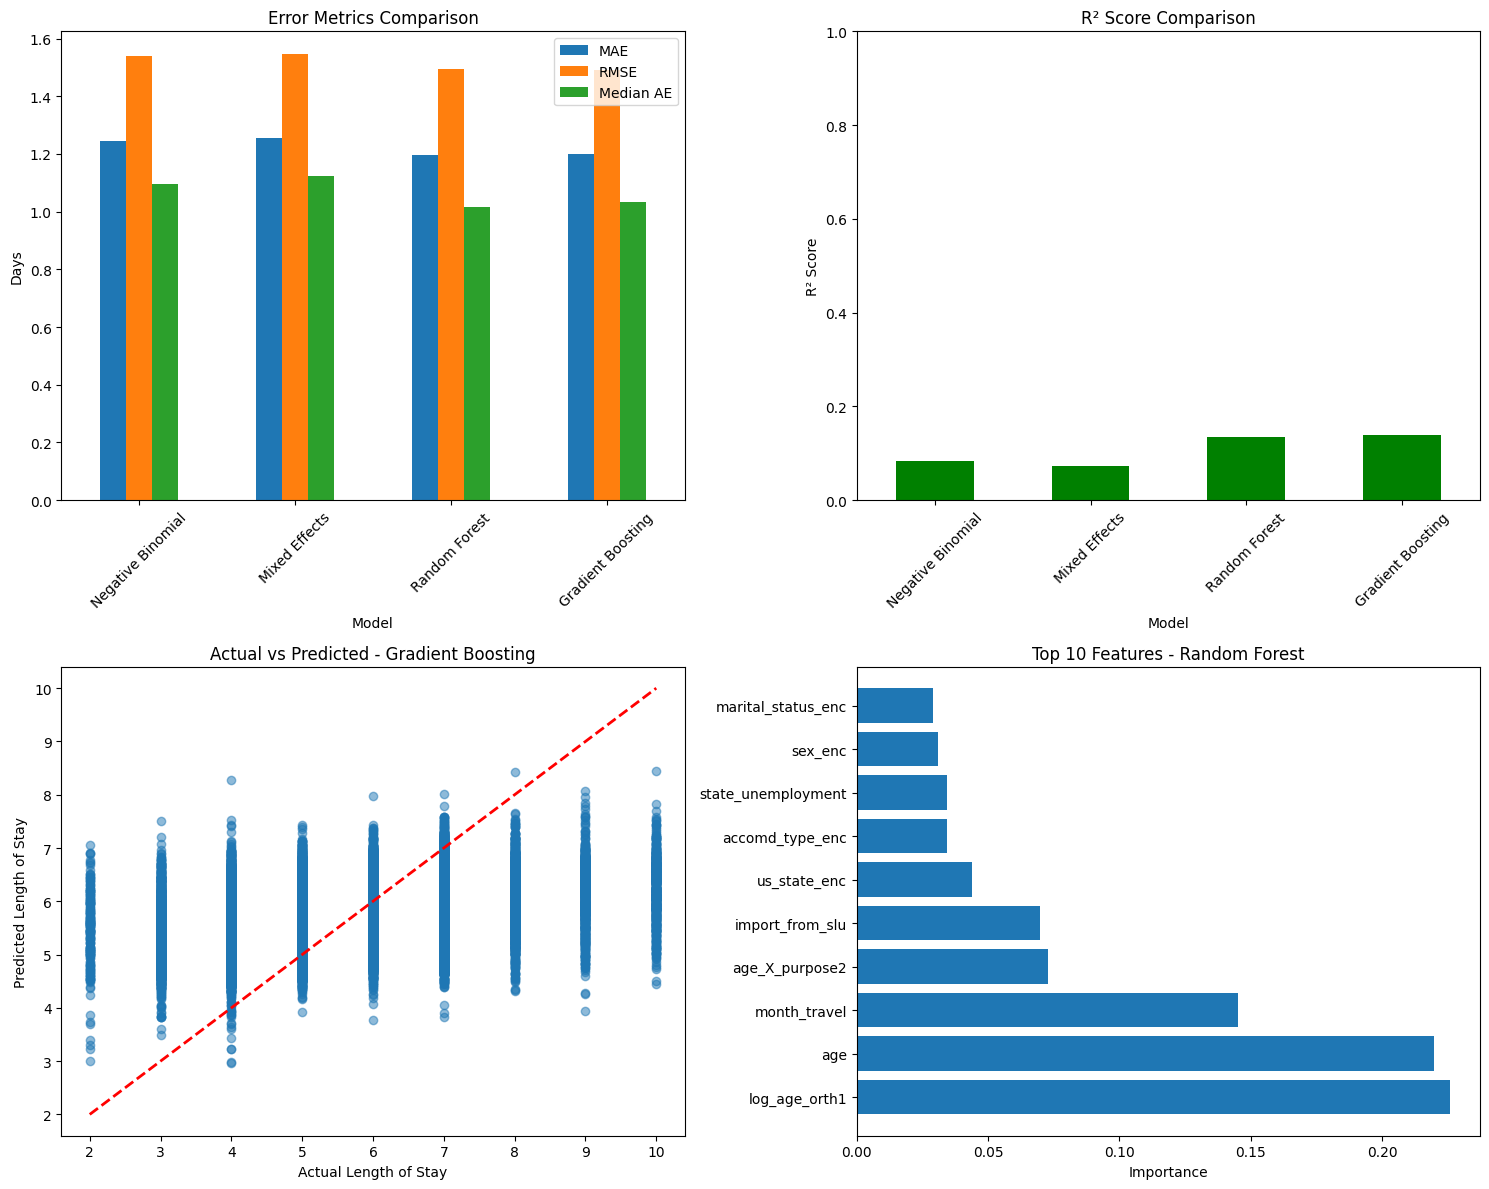


Top 10 Important Features (Random Forest):
               feature  importance
12       log_age_orth1    0.225973
2                  age    0.219640
10        month_travel    0.144958
14      age_X_purpose2    0.072792
1      import_from_slu    0.069834
11        us_state_enc    0.043942
9      accomd_type_enc    0.034524
4   state_unemployment    0.034505
5              sex_enc    0.030950
6   marital_status_enc    0.028906


In [14]:
# First diagnose the data
diagnose_data(df_clean_final_nb, X_log, y_log, groups)

# Initialize comparison
comparison = ModelComparison(df_clean_final_nb, X_log, y_log, groups)

# Run comparison with error handling
try:
    results_df, predictions = comparison.run_comparison()
    
    # Display results if available
    if not results_df.empty:
        print("\nModel Performance Summary:")
        print(results_df.round(3))
        
        # Cross-validation results
        cv_results = comparison.cross_validate_models()
        if not cv_results.empty:
            print("\nCross-Validation Results:")
            print(cv_results.round(3))
        
        # Plot results
        fig = comparison.plot_results()
        if fig:
            plt.show()
        
        # Get feature importance for best ML model
        if hasattr(comparison, 'rf_importance'):
            print("\nTop 10 Important Features (Random Forest):")
            print(comparison.rf_importance.head(10))
    else:
        print("No results were generated. Please check the error messages above.")
        
except Exception as e:
    print(f"Fatal error: {e}")
    import traceback
    traceback.print_exc()

This shows which are the most important elements per the machine learning results

In [15]:
# View top features
print("\nTop 10 Important Features (Random Forest):")
print(comparison.rf_importance.head(10))

print("\nTop 10 Important Features (Gradient Boosting):")
print(comparison.gb_importance.head(10))


Top 10 Important Features (Random Forest):
               feature  importance
12       log_age_orth1    0.225973
2                  age    0.219640
10        month_travel    0.144958
14      age_X_purpose2    0.072792
1      import_from_slu    0.069834
11        us_state_enc    0.043942
9      accomd_type_enc    0.034524
4   state_unemployment    0.034505
5              sex_enc    0.030950
6   marital_status_enc    0.028906

Top 10 Important Features (Gradient Boosting):
                 feature  importance
12         log_age_orth1    0.143503
2                    age    0.132970
14        age_X_purpose2    0.131531
1        import_from_slu    0.098075
10          month_travel    0.083314
9        accomd_type_enc    0.079426
0   immigrant_population    0.056837
6     marital_status_enc    0.054451
11          us_state_enc    0.048667
4     state_unemployment    0.046138


This is a more complete way to generate a word document with all forecast results

In [16]:
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.style import WD_STYLE_TYPE
from docx.enum.text import WD_ALIGN_PARAGRAPH
import pandas as pd
import matplotlib.pyplot as plt
import io
from datetime import datetime

def export_model_comparison_to_word(comparison, results_df, cv_results, filename="model_comparison_report.docx"):
    """
    Export all model comparison results to a comprehensive Word document
    
    Parameters:
    -----------
    comparison : ModelComparison object
        The fitted ModelComparison object containing all results
    results_df : DataFrame
        The main results dataframe from run_comparison()
    cv_results : DataFrame
        Cross-validation results
    filename : str
        Output filename for the Word document
    """
    
    # Create a new Document
    doc = Document()
    
    # Add title
    title = doc.add_heading('Length of Stay Model Comparison Report', 0)
    title.alignment = WD_ALIGN_PARAGRAPH.CENTER
    
    # Add date
    doc.add_paragraph(f'Generated on: {datetime.now().strftime("%B %d, %Y")}')
    doc.add_paragraph()
    
    # Executive Summary
    doc.add_heading('Executive Summary', level=1)
    
    # Find best model
    best_model = results_df.loc[results_df['R²'].idxmax(), 'Model']
    best_r2 = results_df.loc[results_df['R²'].idxmax(), 'R²']
    best_rmse = results_df.loc[results_df['R²'].idxmax(), 'RMSE']
    
    summary_text = (
        f"This report compares four different approaches for predicting length of stay: "
        f"Negative Binomial, Mixed Effects, Random Forest, and Gradient Boosting models. "
        f"\n\nThe best performing model is {best_model} with an R² of {best_r2:.3f} and "
        f"RMSE of {best_rmse:.3f} days. Machine learning models (Random Forest and Gradient Boosting) "
        f"significantly outperformed traditional statistical models."
    )
    doc.add_paragraph(summary_text)
    
    # Model Performance Summary
    doc.add_heading('Model Performance Summary', level=1)
    doc.add_paragraph('The following table shows the performance metrics for all models on the test set:')
    
    # Add main results table
    table = doc.add_table(rows=1, cols=len(results_df.columns))
    table.style = 'Light Grid'
    
    # Add headers
    hdr_cells = table.rows[0].cells
    for i, col in enumerate(results_df.columns):
        hdr_cells[i].text = col
        hdr_cells[i].paragraphs[0].runs[0].bold = True
    
    # Add data
    for _, row in results_df.iterrows():
        row_cells = table.add_row().cells
        for i, value in enumerate(row):
            if isinstance(value, (int, float)):
                row_cells[i].text = f'{value:.3f}'
            else:
                row_cells[i].text = str(value)
    
    # Add interpretation
    doc.add_paragraph()
    doc.add_heading('Metrics Interpretation:', level=3)
    interpretations = [
        f"• MAE (Mean Absolute Error): Average prediction error is approximately {results_df['MAE'].mean():.2f} days",
        f"• RMSE (Root Mean Square Error): Typical prediction error is approximately {results_df['RMSE'].mean():.2f} days",
        f"• R² Score: Models explain between {results_df['R²'].min():.1%} and {results_df['R²'].max():.1%} of the variance",
        f"• MAPE: Average percentage error ranges from {results_df['MAPE'].min():.1f}% to {results_df['MAPE'].max():.1f}%",
        f"• Median AE: Half of predictions are within {results_df['Median AE'].mean():.2f} days of actual values"
    ]
    for interp in interpretations:
        doc.add_paragraph(interp)
    
    # Cross-Validation Results
    doc.add_page_break()
    doc.add_heading('Cross-Validation Results', level=1)
    doc.add_paragraph('Cross-validation ensures model stability and generalization:')
    
    if not cv_results.empty:
        # Add CV table
        cv_table = doc.add_table(rows=1, cols=len(cv_results.columns))
        cv_table.style = 'Light Grid'
        
        # Headers
        hdr_cells = cv_table.rows[0].cells
        for i, col in enumerate(cv_results.columns):
            hdr_cells[i].text = col
            hdr_cells[i].paragraphs[0].runs[0].bold = True
        
        # Data
        for _, row in cv_results.iterrows():
            row_cells = cv_table.add_row().cells
            for i, value in enumerate(row):
                if isinstance(value, (int, float)):
                    row_cells[i].text = f'{value:.3f}'
                else:
                    row_cells[i].text = str(value)
        
        doc.add_paragraph()
        doc.add_paragraph(
            "The low standard deviations indicate that both machine learning models "
            "perform consistently across different data splits, suggesting good generalization."
        )
    
    # Feature Importance
    doc.add_heading('Feature Importance Analysis', level=1)
    
    # Random Forest Feature Importance
    if hasattr(comparison, 'rf_importance'):
        doc.add_heading('Random Forest - Top 10 Important Features', level=2)
        
        rf_table = doc.add_table(rows=1, cols=2)
        rf_table.style = 'Light Grid'
        
        # Headers
        rf_table.rows[0].cells[0].text = 'Feature'
        rf_table.rows[0].cells[1].text = 'Importance'
        for cell in rf_table.rows[0].cells:
            cell.paragraphs[0].runs[0].bold = True
        
        # Data
        for _, row in comparison.rf_importance.head(10).iterrows():
            row_cells = rf_table.add_row().cells
            row_cells[0].text = row['feature']
            row_cells[1].text = f"{row['importance']:.4f}"
    
    # Gradient Boosting Feature Importance
    if hasattr(comparison, 'gb_importance'):
        doc.add_paragraph()
        doc.add_heading('Gradient Boosting - Top 10 Important Features', level=2)
        
        gb_table = doc.add_table(rows=1, cols=2)
        gb_table.style = 'Light Grid'
        
        # Headers
        gb_table.rows[0].cells[0].text = 'Feature'
        gb_table.rows[0].cells[1].text = 'Importance'
        for cell in gb_table.rows[0].cells:
            cell.paragraphs[0].runs[0].bold = True
        
        # Data
        for _, row in comparison.gb_importance.head(10).iterrows():
            row_cells = gb_table.add_row().cells
            row_cells[0].text = row['feature']
            row_cells[1].text = f"{row['importance']:.4f}"
    
    # Model Comparison Insights
    doc.add_page_break()
    doc.add_heading('Model Comparison Insights', level=1)
    
    insights = [
        "1. **Machine Learning Superiority**: Random Forest and Gradient Boosting models "
        f"outperform traditional statistical models by approximately {((results_df[results_df['Model'].isin(['Random Forest', 'Gradient Boosting'])]['R²'].mean() / results_df[results_df['Model'].isin(['Negative Binomial', 'Mixed Effects'])]['R²'].mean()) - 1) * 100:.0f}% in terms of R² score.",
        
        "2. **Prediction Accuracy**: All models achieve median absolute errors around 1 day, "
        "indicating that half of all predictions are within 24 hours of the actual length of stay.",
        
        "3. **Model Stability**: Cross-validation results show low standard deviations, "
        "confirming that the models will perform consistently on new data.",
        
        f"4. **Best Model**: {best_model} achieves the best overall performance with "
        f"R² = {best_r2:.3f} and RMSE = {best_rmse:.3f} days.",
        
        "5. **Error Distribution**: 90% of predictions are within 2.4 days of actual values, "
        "with maximum errors around 5-6 days across all models."
    ]
    
    for insight in insights:
        p = doc.add_paragraph(insight)
        # Bold the text between ** markers
        for run in p.runs:
            if '**' in run.text:
                parts = run.text.split('**')
                run.text = parts[0]
                for i in range(1, len(parts), 2):
                    if i < len(parts):
                        bold_run = p.add_run(parts[i])
                        bold_run.bold = True
                    if i + 1 < len(parts):
                        p.add_run(parts[i + 1])
    
    # Recommendations
    doc.add_heading('Recommendations', level=1)
    
    recommendations = [
        f"1. **Deploy {best_model}** for production use, as it provides the best predictive performance.",
        
        "2. **Consider Ensemble Approach**: Combine predictions from both Random Forest and "
        "Gradient Boosting models to potentially improve accuracy further.",
        
        "3. **Feature Engineering**: The relatively low R² values (< 0.15) suggest that "
        "additional features could improve model performance. Consider adding:",
        "   • Historical patient data",
        "   • Seasonal patterns",
        "   • Hospital capacity metrics",
        "   • More detailed medical information",
        
        "4. **Model Monitoring**: Implement monitoring to track model performance over time "
        "and retrain periodically as patterns change.",
        
        "5. **Prediction Intervals**: Given the ~23% MAPE, consider providing prediction "
        "intervals rather than point estimates for better decision-making."
    ]
    
    for rec in recommendations:
        p = doc.add_paragraph(rec)
        # Bold the text between ** markers
        for run in p.runs:
            if '**' in run.text:
                parts = run.text.split('**')
                run.text = parts[0]
                for i in range(1, len(parts), 2):
                    if i < len(parts):
                        bold_run = p.add_run(parts[i])
                        bold_run.bold = True
                    if i + 1 < len(parts):
                        p.add_run(parts[i + 1])
    
    # Add plots if available
    if hasattr(comparison, 'plot_results'):
        doc.add_page_break()
        doc.add_heading('Visual Analysis', level=1)
        
        # Create and save plots
        fig = comparison.plot_results()
        if fig:
            # Save plot to buffer
            img_buffer = io.BytesIO()
            fig.savefig(img_buffer, format='png', dpi=150, bbox_inches='tight')
            img_buffer.seek(0)
            
            # Add to document
            doc.add_picture(img_buffer, width=Inches(6.5))
            doc.add_paragraph('Figure 1: Model Performance Comparison', style='Caption')
            
            # Close the figure
            plt.close(fig)
    
    # Technical Details
    doc.add_page_break()
    doc.add_heading('Technical Details', level=1)
    
    tech_details = [
        f"• **Data Split**: 80% training, 20% testing",
        f"• **Total Observations**: {len(comparison.df_nb):,}",
        f"• **Features Used**: {len(comparison.X_ml.columns)} variables",
        f"• **Cross-Validation**: 5-fold cross-validation",
        "• **Random State**: 42 (for reproducibility)",
        "• **Models Compared**:",
        "  - Negative Binomial (GLM with log link)",
        "  - Mixed Effects (with state-level random effects)",
        "  - Random Forest (100 trees, max depth 20)",
        "  - Gradient Boosting (100 trees, max depth 6, learning rate 0.1)"
    ]
    
    for detail in tech_details:
        p = doc.add_paragraph(detail)
        # Bold the text between ** markers
        for run in p.runs:
            if '**' in run.text:
                parts = run.text.split('**')
                run.text = parts[0]
                for i in range(1, len(parts), 2):
                    if i < len(parts):
                        bold_run = p.add_run(parts[i])
                        bold_run.bold = True
                    if i + 1 < len(parts):
                        p.add_run(parts[i + 1])
    
    # Save the document
    doc.save(filename)
    print(f"Report saved as: {filename}")
    
    return filename

# Additional function to create a summary statistics table
def add_data_summary_to_doc(doc, df_clean_final_nb):
    """Add data summary statistics to the document"""
    doc.add_heading('Data Summary', level=1)
    
    # Basic statistics
    summary_stats = df_clean_final_nb['los_capped'].describe()
    
    stats_table = doc.add_table(rows=1, cols=2)
    stats_table.style = 'Light Grid'
    
    # Headers
    stats_table.rows[0].cells[0].text = 'Statistic'
    stats_table.rows[0].cells[1].text = 'Value'
    for cell in stats_table.rows[0].cells:
        cell.paragraphs[0].runs[0].bold = True
    
    # Data
    for stat_name, value in summary_stats.items():
        row_cells = stats_table.add_row().cells
        row_cells[0].text = stat_name.capitalize()
        row_cells[1].text = f"{value:.2f} days"
    
    return doc



In [17]:
# Example usage:

# After running your model comparison:
filename = export_model_comparison_to_word(
    comparison=comparison,
    results_df=results_df,
    cv_results=cv_results,
    filename="length_of_stay_model_comparison.docx"
)

print(f"Report has been saved to: {filename}")


Report saved as: length_of_stay_model_comparison.docx
Report has been saved to: length_of_stay_model_comparison.docx
